# **1. Install packages**

In [1]:
%%capture
!pip install torchinfo

# **2. Import libraries**

In [2]:
# Data handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split

# Torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.models import vit_b_16, ViT_B_16_Weights

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# os
import os

# tqdm
from tqdm.auto import tqdm

# Path
from pathlib import Path

# random
import random

# OrderedDict
from collections import OrderedDict

# typing
from typing import Dict, List

# warnings
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **3. Load data and EDA**

In [3]:
# Total Images
IMAGE_PATH = Path("/kaggle/input/tomatofruits/Three Classes")

IMAGE_PATH_LIST = list(IMAGE_PATH.glob("*/*.jpg"))

print(f'Total Images = {len(IMAGE_PATH_LIST)}')

Total Images = 2400


In [4]:
# Number of images per class.
classes = os.listdir(IMAGE_PATH)
classes = sorted(classes)

print('==' * 20)
print(' ' * 10, f'Total Classes = {len(classes)}')
print('==' * 20)
for c in classes:
    total_images_class = list(Path(os.path.join(IMAGE_PATH, c)).glob("*.jpg"))
    print(f'- {c}: {len(total_images_class)} images')

           Total Classes = 3
- Reject: 800 images
- Ripe: 800 images
- Unripe: 800 images


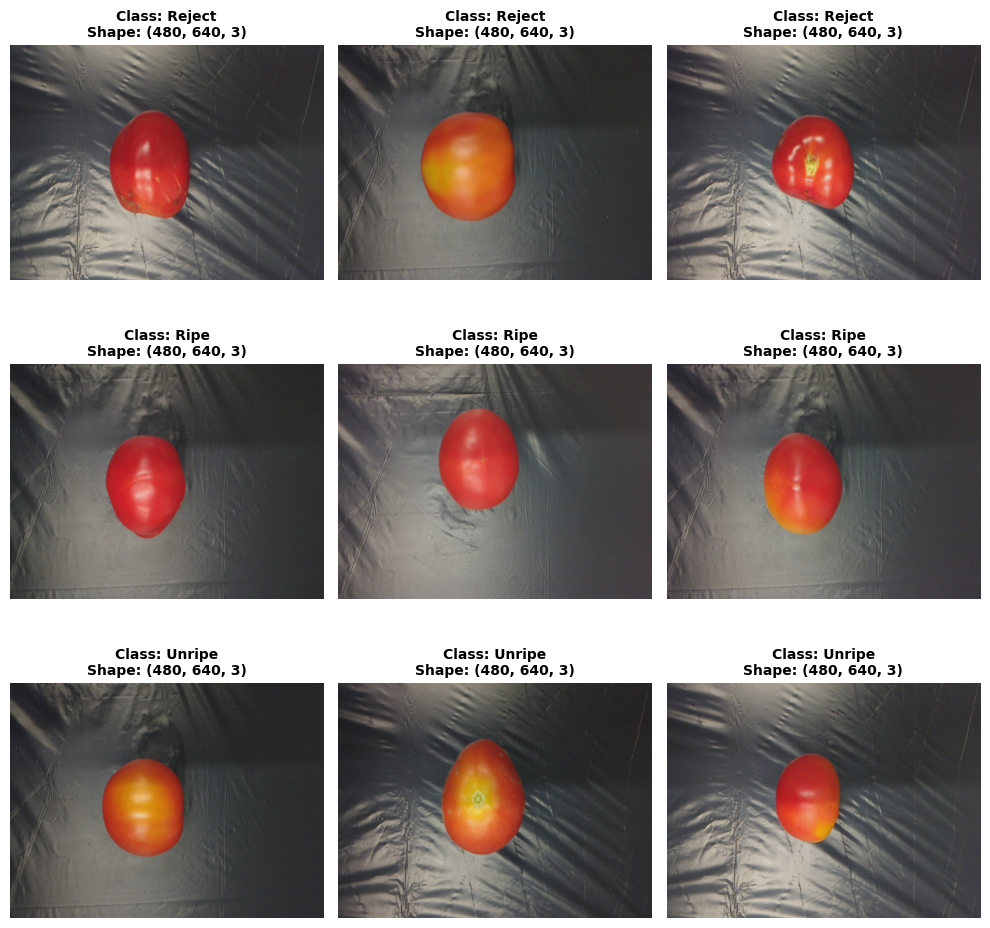

In [5]:
# We view some images for each class.
NUM_IMAGES = 3

fig, ax = plt.subplots(nrows = len(classes), ncols = NUM_IMAGES, figsize = (10,10))
p = 0
for c in classes:
    total_images_class = list(Path(os.path.join(IMAGE_PATH, c)).glob("*.jpg"))
    images_selected = random.choices(total_images_class, k = NUM_IMAGES)
    
    for i,img_path in enumerate(images_selected):
        img_bgr = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        ax[p,i].imshow(img_rgb)
        ax[p,i].axis("off")
        ax[p,i].set_title(f"Class: {c}\nShape: {img_rgb.shape}", fontsize = 10, fontweight = "bold", color = "black")
        
    p += 1
    
fig.tight_layout()
fig.show()

# **4. Preprocessing**

Let's create a dataframe with two columns:

- the first **path** call will store the paths of the images.
- the second call **label** that will contain the labels of each image.

In [6]:
images_path = [None] * len(IMAGE_PATH_LIST)
labels = [None] * len(IMAGE_PATH_LIST)

for i,image_path in enumerate(IMAGE_PATH_LIST):
    images_path[i] = image_path
    labels[i] = image_path.parent.stem
    
df_path_and_label = pd.DataFrame({'path':images_path, 
                                  'label':labels})
df_path_and_label.head()

,path,label
0,/kaggle/input/tomatofruits/Three Classes/Unrip...,Unripe
1,/kaggle/input/tomatofruits/Three Classes/Unrip...,Unripe
2,/kaggle/input/tomatofruits/Three Classes/Unrip...,Unripe
3,/kaggle/input/tomatofruits/Three Classes/Unrip...,Unripe
4,/kaggle/input/tomatofruits/Three Classes/Unrip...,Unripe


Now we have to divide our dataframe into 3 datasets:

- **train = 70%**
- **valid = 15%**
- **test = 15%**

In [7]:
SEED = 42

df_train, df_rest = train_test_split(df_path_and_label, 
                                     test_size = 0.3, 
                                     random_state = SEED, 
                                     stratify = df_path_and_label["label"])

df_val, df_test = train_test_split(df_rest, 
                                  test_size = 0.5, 
                                  random_state = SEED, 
                                  stratify = df_rest["label"])

In [8]:
# We have to define the mapping of the classes to convert the labels to numbers.
label_map = dict(zip(classes, range(0, len(classes))))
label_map

{'Reject': 0, 'Ripe': 1, 'Unripe': 2}

In [9]:
# Now we define the transformations that we are going to apply.
weights = ViT_B_16_Weights.DEFAULT
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

Now we are going to create the **Dataset's** and **DataLoader's**.

Let's start with the **Dataset's**.

In [10]:
class CustomDataset(Dataset):
    def __init__(self, df:pd.DataFrame, label_map:dict, transforms):
        self.df = df
        self.label_map = label_map
        self.transforms = transforms
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        df_new = self.df.copy()
        df_new = df_new.reset_index(drop = True)
        df_new["label"] = df_new["label"].map(self.label_map)
        image_path = df_new.iloc[idx, 0]
        image = Image.open(image_path).convert("RGB")
        image = self.transforms(image)
        label = df_new.iloc[idx, 1]
        
        return image, label

In [11]:
train_dataset = CustomDataset(df_train, label_map, auto_transforms)
valid_dataset = CustomDataset(df_val, label_map, auto_transforms)

**DataLoader's**

In [12]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset = train_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True, 
                              num_workers = NUM_WORKERS)
valid_dataloader = DataLoader(dataset = valid_dataset, 
                              batch_size = BATCH_SIZE, 
                              shuffle = True, 
                              num_workers = NUM_WORKERS)

In [13]:
# Let's visualize the dimensions of a batch.
batch_images, batch_labels = next(iter(train_dataloader))

batch_images.shape, batch_labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

# **5. Model**

In [14]:
# GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [15]:
# We define the model to use with the pre-trained weights.
model = vit_b_16(weights = weights)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 243MB/s]  


In [16]:
# Let's visualize the architecture of the model.
summary(model = model, 
        input_size = [32, 3, 224, 224], 
        col_names = ["input_size", "output_size", "num_params", "trainable"], 
        col_width = 15, 
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224] [32, 1000]      768             True
├─Conv2d (conv_proj)                                         [32, 3, 224, 224] [32, 768, 14, 14] 590,592         True
├─Encoder (encoder)                                          [32, 197, 768]  [32, 197, 768]  151,296         True
│    └─Dropout (dropout)                                     [32, 197, 768]  [32, 197, 768]  --              --
│    └─Sequential (layers)                                   [32, 197, 768]  [32, 197, 768]  --              True
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]  [32, 197, 768]  7,087,872       True
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]  [32, 197, 768]  7,087,872       True
│    │    └─EncoderBlock (encoder_layer_2)                   [32, 197, 768]  [3

We are going to **freeze the parameters of the conv_proj and encoder layers**.

In [17]:
for param in model.conv_proj.parameters():
    param.requires_grad = False

In [18]:
for param in model.encoder.parameters():
    param.requires_grad = False

In [19]:
# Let's see if the parameters were frozen.
summary(model = model, 
        input_size = [32,3,224,224], 
        col_names = ["input_size", "output_size", "num_params", "trainable"], 
        col_width = 15,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224] [32, 1000]      768             Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224] [32, 768, 14, 14] (590,592)       False
├─Encoder (encoder)                                          [32, 197, 768]  [32, 197, 768]  151,296         False
│    └─Dropout (dropout)                                     [32, 197, 768]  [32, 197, 768]  --              --
│    └─Sequential (layers)                                   [32, 197, 768]  [32, 197, 768]  --              False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]  [32, 197, 768]  (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]  [32, 197, 768]  (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_2)                   [32, 197, 

Great!!, the parameters were frozen.

Let's visualize the last layer which we will modify the number of **out_features**, in this case it is the number of **classes** we have.

In [20]:
output_shape = len(classes)

model.heads = nn.Sequential(OrderedDict([('head', nn.Linear(in_features = 768, 
                                                            out_features = output_shape))]))

In [21]:
# One last time let's take a look if the last layer was modified.
summary(model = model, 
        input_size = [32,3,224,224], 
        col_names = ["input_size", "output_size", "num_params", "trainable"], 
        col_width = 15,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224] [32, 3]         768             Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224] [32, 768, 14, 14] (590,592)       False
├─Encoder (encoder)                                          [32, 197, 768]  [32, 197, 768]  151,296         False
│    └─Dropout (dropout)                                     [32, 197, 768]  [32, 197, 768]  --              --
│    └─Sequential (layers)                                   [32, 197, 768]  [32, 197, 768]  --              False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]  [32, 197, 768]  (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]  [32, 197, 768]  (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_2)                   [32, 197, 

Let's define the **loss function** and the **optimizer**.

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

We are going to define 3 functions for training and one to store the best model:

- **train_step**
- **save_checkpoint**
- **valid_step**
- **train**

In [23]:
def train_step(model:torch.nn.Module, 
               dataloader:torch.utils.data.DataLoader, 
               loss_fn:torch.nn.Module, 
               optimizer:torch.optim.Optimizer):
    
    model.train()
    
    train_loss = 0.
    train_accuracy = 0.
    
    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred_logit = model(X)
        loss = loss_fn(y_pred_logit, y)
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
        y_pred_class = torch.argmax(y_pred_prob, dim = 1)
        train_accuracy += accuracy_score(y.cpu().numpy(), 
                                         y_pred_class.detach().cpu().numpy())
        
    train_loss = train_loss/len(dataloader)
    train_accuracy = train_accuracy/len(dataloader)
    
    return train_loss, train_accuracy

In [24]:
def save_checkpoint(filename, model, loss, epoch, optimizer, metric):
    state = {"filename":filename, 
             "model":model.state_dict(), 
             "loss":loss, 
             "epoch":epoch, 
             "optimizer":optimizer.state_dict(), 
             "metric":metric}
    
    torch.save(state, filename)

In [25]:
def valid_step(model:torch.nn.Module, 
               dataloader:torch.utils.data.DataLoader, 
               loss_fn:torch.nn.Module):
    
    model.eval()
    
    valid_loss = 0.
    valid_accuracy = 0.
    
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device)
            y_pred_logit = model(X)
            loss = loss_fn(y_pred_logit, y)
            valid_loss += loss.item()
            
            y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
            y_pred_class = torch.argmax(y_pred_prob, dim = 1)
            
            valid_accuracy += accuracy_score(y.cpu().numpy(), y_pred_class.detach().cpu().numpy())
            
    valid_loss = valid_loss/len(dataloader)
    valid_accuracy = valid_accuracy/len(dataloader)
    
    return valid_loss, valid_accuracy

In [26]:
def train(model:torch.nn.Module, 
          train_dataloader:torch.utils.data.DataLoader, 
          valid_dataloader:torch.utils.data.DataLoader, 
          loss_fn:torch.nn.Module, 
          optimizer:torch.optim.Optimizer, 
          epochs:int = 10):
    
    results = {"train_loss":[], 
               "train_accuracy":[], 
               "valid_loss":[], 
               "valid_accuracy":[]}
    
    best_valid_loss = float("inf")
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step(model = model, 
                                                dataloader = train_dataloader, 
                                                loss_fn = loss_fn, 
                                                optimizer = optimizer)
        
        valid_loss, valid_accuracy = valid_step(model = model, 
                                                dataloader = valid_dataloader, 
                                                loss_fn = loss_fn)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            file_name = "best_model.pth"
            save_checkpoint(file_name, model, best_valid_loss, epoch, optimizer, valid_accuracy)
            
        print(f"Epoch: {epoch + 1} | ", 
              f"Train Loss: {train_loss:.4f} | ", 
              f"Train Accuracy: {train_accuracy:.4f} | ", 
              f"Valid Loss: {valid_loss:.4f} | ", 
              f"Valid Accuracy: {valid_accuracy:.4f}")
        
        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy)
        results["valid_loss"].append(valid_loss)
        results["valid_accuracy"].append(valid_accuracy)
        
    return results

In [27]:
# Training!!!
EPOCHS = 50

torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

MODEL_RESULTS = train(model.to(device), 
                      train_dataloader, 
                      valid_dataloader, 
                      loss_fn, 
                      optimizer, 
                      EPOCHS)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 0.4397 |  Train Accuracy: 0.8331 |  Valid Loss: 0.4609 |  Valid Accuracy: 0.8542
Epoch: 2 |  Train Loss: 0.3139 |  Train Accuracy: 0.8803 |  Valid Loss: 0.3798 |  Valid Accuracy: 0.8568
Epoch: 3 |  Train Loss: 0.3078 |  Train Accuracy: 0.8874 |  Valid Loss: 0.3739 |  Valid Accuracy: 0.8724
Epoch: 4 |  Train Loss: 0.2563 |  Train Accuracy: 0.9039 |  Valid Loss: 0.3967 |  Valid Accuracy: 0.8698
Epoch: 5 |  Train Loss: 0.3739 |  Train Accuracy: 0.8721 |  Valid Loss: 0.4650 |  Valid Accuracy: 0.8802
Epoch: 6 |  Train Loss: 0.2706 |  Train Accuracy: 0.9027 |  Valid Loss: 0.3707 |  Valid Accuracy: 0.8932
Epoch: 7 |  Train Loss: 0.3169 |  Train Accuracy: 0.8868 |  Valid Loss: 0.4629 |  Valid Accuracy: 0.8594
Epoch: 8 |  Train Loss: 0.2620 |  Train Accuracy: 0.9145 |  Valid Loss: 0.2701 |  Valid Accuracy: 0.9167
Epoch: 9 |  Train Loss: 0.1792 |  Train Accuracy: 0.9369 |  Valid Loss: 0.2795 |  Valid Accuracy: 0.9115
Epoch: 10 |  Train Loss: 0.1537 |  Train Accuracy: 0.94

In [28]:
# Function to plot the loss and metric during each training epoch.
def loss_metric_curve_plot(model_results:Dict[str,List[float]]):
    
    train_loss = model_results["train_loss"]
    valid_loss = model_results["valid_loss"]
    
    train_accuracy = [float(value) for value in model_results["train_accuracy"]]
    valid_accuracy = [float(value) for value in model_results["valid_accuracy"]]
    
    fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
    axes = axes.flat
    
    axes[0].plot(train_loss, color = "red", label = "Train")
    axes[0].plot(valid_loss, color = "blue", label = "Valid")
    axes[0].set_title("CrossEntropyLoss", fontsize = 12, fontweight = "bold", color = "black")
    axes[0].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].set_ylabel("Loss", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].legend()
    
    axes[1].plot(train_accuracy, color = "red", label = "Train")
    axes[1].plot(valid_accuracy, color = "blue", label = "Valid")
    axes[1].set_title("Metric of performance: Accuracy", fontsize = 12, fontweight = "bold", color = "black")
    axes[1].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].set_ylabel("Score", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].legend()
    
    fig.tight_layout()
    fig.show()

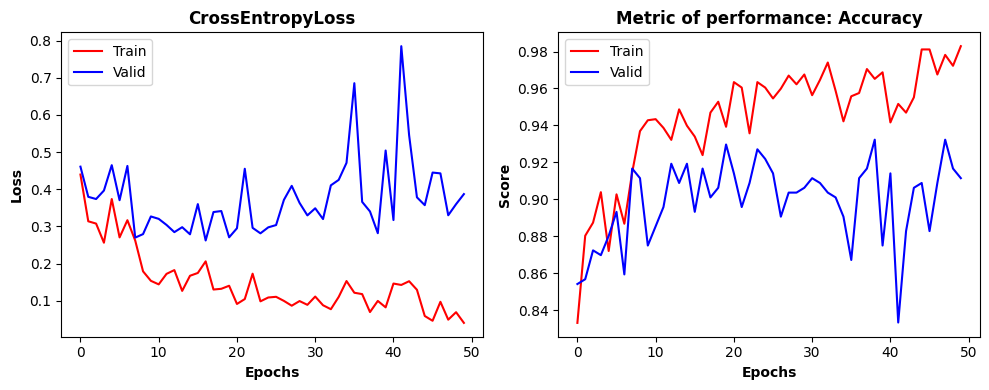

In [29]:
loss_metric_curve_plot(MODEL_RESULTS)

In [30]:
# Let's load the best model.
checkpoint_path = "/kaggle/working/best_model.pth"
checkpoint = torch.load(checkpoint_path)

In [31]:
# Now let's look at the smallest loss, its metric and when it occurred.
print(f'Best Loss: {checkpoint["loss"]}')
print(f'Epoch: {checkpoint["epoch"] + 1}')
print(f'Best Metric: {checkpoint["metric"]}')

Best Loss: 0.2623283118785669
Epoch: 17
Best Metric: 0.9166666666666666


Well, now we have to predict the images of the test set.

- **Predictions**

In [32]:
# First of all, we create the Dataset, DataLoader
test_dataset = CustomDataset(df_test, label_map, auto_transforms)
test_dataloader = DataLoader(dataset = test_dataset, shuffle = False, num_workers = NUM_WORKERS)

In [33]:
# We define the model again with its respective modification.
loaded_model = vit_b_16()

loaded_model.heads = nn.Sequential(OrderedDict([('head',nn.Linear(in_features = 768, 
                                                                  out_features = output_shape))]))

loaded_model.load_state_dict(checkpoint["model"])

# We now infer
loaded_model.to(device)

loaded_model.eval()

y_pred_test = []

with torch.inference_mode():
    for X,y in tqdm(test_dataloader):
        X,y = X.to(device), y.to(device)
        y_pred_logit = loaded_model(X)
        y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
        y_pred_class = torch.argmax(y_pred_prob, dim = 1)
        y_pred_test.append(y_pred_class.detach().cpu())

  0%|          | 0/360 [00:00<?, ?it/s]

In [34]:
y_pred_test = torch.cat(y_pred_test).numpy()

# **6. Metrics**

- **Accuracy**

In [35]:
print(f'Accuracy Test = {round(accuracy_score(df_test["label"].map(label_map), y_pred_test), 4)}')

Accuracy Test = 0.9083


- **Confusion Matrix**

In [36]:
confusion_matrix_test = confusion_matrix(df_test["label"].map(label_map), y_pred_test)

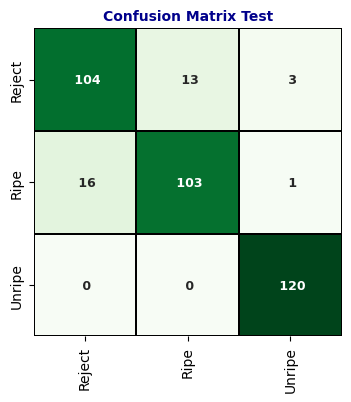

In [37]:
fig,ax = plt.subplots(figsize = (15,4))
sns.heatmap(confusion_matrix_test, 
            cmap = 'Greens', 
            annot = True, 
            annot_kws = {"fontsize":9, "fontweight":"bold"}, 
            linewidths = 1.2, 
            fmt = ' ',
            linecolor = "black", 
            square = True, 
            xticklabels = classes, 
            yticklabels = classes, 
            cbar = False,
            ax = ax)
ax.set_title("Confusion Matrix Test", fontsize = 10, fontweight = "bold", color = "darkblue")
ax.tick_params('x',rotation = 90)
fig.show()